In [1]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import resnet50
import pandas as pd
import numpy as np
import os
import cv2

# We first work with resnet_50

In [2]:
labels = pd.read_csv('Data/train_label.csv')
labels.head()

,Unnamed: 0,id,Type
0,0,distribute_40,distribute
1,1,distribute_41,distribute
2,2,distribute_42,distribute
3,3,distribute_43,distribute
4,4,distribute_44,distribute


In [3]:
labels['Type'].value_counts()

limit         360
ineq          360
integral      360
series        360
matrix        360
distribute    360
sqrt          360
Name: Type, dtype: int64

In [4]:
sample = pd.read_csv('Data/sample_submission.csv')
sample.head()

,id,distribute,ineq,integral,limit,matrix,series,sqrt
0,distribute_40,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,distribute_41,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,distribute_42,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,distribute_43,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,distribute_44,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [5]:
# num_train_images = labels.shape[0]
num_train_images = 2520  # we choose 3300 images for this assignment. It works for a machine having 8Gb Ram. You can adjust it if your Ram is different. 
split_point = 2240 # split the data into training data [0:3000] and val data [3000:]
print('num_train_images:', num_train_images)
types = sample.columns[1:]
print('Types:', types)
num_classes = len(types)
print('num_classes:', num_classes)

num_train_images: 2520
Types: Index(['distribute', 'ineq', 'integral', 'limit', 'matrix', 'series', 'sqrt'], dtype='object')
num_classes: 7


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_width = 224

def get_image(filename):
    ########################################################################
    # TODO: Your code here...
    ########################################################################
    original = load_img(filename, target_size=(224,224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    return image_batch[0]


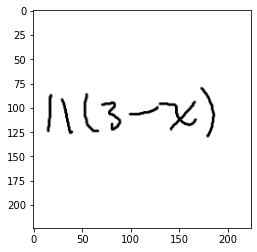

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

image = get_image('Data/train/distribute_41.png')
plt.imshow(np.uint8(image))
plt.show()

In [8]:
x_train = np.zeros((num_train_images, img_width, img_width, 3), dtype=np.uint8)
y_train = np.zeros((num_train_images, num_classes), dtype=np.uint8)

count = 0

for i in range(num_train_images):
    x_train[i] = get_image('Data/train/%s.png' % labels['id'][i])
    pos_arrays = (types == labels['Type'][i]).nonzero() # recall that types is the array of classes
    pos = pos_arrays[0][0]
    y_train[i][pos] = 1
    count += 1
    if(count % 1000 == 0): print(count, 'images loaded')

1000 images loaded
2000 images loaded


In [9]:
from tensorflow.keras.applications import resnet50

x_train = resnet50.preprocess_input(x_train) # preprocess the images properly (e.g., minus the mean image)

In [10]:
model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top=False)
# include_top=False --> do not load the last FC layer

In [11]:
#x_train_mini=np.expand_dims(x_train_test, axis=0)
#features = model_resnet50.predict(x_train_test, batch_size=1, verbose=1)
features = model_resnet50.predict(x_train, batch_size=64, verbose=1)

40/40 [==============================] - 204s 5s/step


In [12]:
# Using 7 x 7 x 2048 features as input to an FC layer leads to many parameters, and may overfit for small dataset
# Our solution is to use global pooling: pooling over every 7 x 7 images, to obtain 2048 features only
# -> ref: https://arxiv.org/pdf/1312.4400.pdf Sec 3.2

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization

# define the network
# NOTE:
# here we use "output = Layer(configs) (input)" + model(inputs, outputs)
# you may also use model.add(layer) when building your own sequential model
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [13]:
from tensorflow.keras.models import Model

model = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 500)               1024500   
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 500)               0     

In [14]:
# Assign loss function (over the output), optimizer algorithm, etc.
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [15]:
# Let's use first 3000 images for training, last 300 for validation
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model.fit(features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 2s 55ms/step - loss: 1.4636 - accuracy: 0.5031 - val_loss: 1.7556 - val_accuracy: 0.3143
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 0.7279 - accuracy: 0.7464 - val_loss: 0.2385 - val_accuracy: 0.9071
Epoch 3/30
18/18 [==============================] - 1s 37ms/step - loss: 0.5957 - accuracy: 0.7821 - val_loss: 0.0965 - val_accuracy: 0.9571
Epoch 4/30
18/18 [==============================] - 1s 38ms/step - loss: 0.5113 - accuracy: 0.8138 - val_loss: 0.0525 - val_accuracy: 0.9893
Epoch 5/30
18/18 [==============================] - 1s 38ms/step - loss: 0.4548 - accuracy: 0.8411 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 6/30
18/18 [==============================] - 1s 42ms/step - loss: 0.4152 - accuracy: 0.8562 - val_loss: 0.0423 - val_accuracy: 0.9929
Epoch 7/30
18/18 [==============================] - 1s 38ms/step - loss: 0.3619 - accuracy: 0.8737 - val_loss: 0.0391 - val_accuracy: 0.9929
Epoch 8/30
18

In [16]:
# save it to disk
model.save('model1.h5') # you may try load_model.ipynb to see how it's loaded (not required)

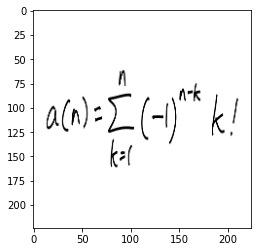

In [20]:
test_img = get_image('Data/Test_2/series_15.png')
plt.imshow(np.uint8(test_img))
plt.show()

In [21]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = resnet50.preprocess_input(image_batch)
feature_input = model_resnet50.predict(image_batch)
predictions = model.predict(feature_input)
pos = np.argmax(predictions)
types[pos]

'series'

## This is where we test our model

- "Test" data : from the same pool of data (total data: 2800, Test data: 280)
- "Test_2" data : similar pool of data but different set (280)
- "Test_3" data : samples collected from different people

In [21]:
for files in os.listdir('./Data/Test_3/'):
    
    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'Data/Test_3/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = model_resnet50.predict(image_batch)
        predictions = model.predict(feature_input)
        pos = np.argmax(predictions)

        print('Image Name: ',files,' Prediction: ',types[pos])


Image Name:  f_dist_1.png  Prediction:  distribute
Image Name:  f_ineq.png  Prediction:  ineq
Image Name:  f_int.png  Prediction:  distribute
Image Name:  f_lim.png  Prediction:  limit
Image Name:  f_matrix.png  Prediction:  matrix
Image Name:  f_series.png  Prediction:  series
Image Name:  f_sqrt.png  Prediction:  sqrt
Image Name:  s_dist3.png  Prediction:  ineq
Image Name:  s_ineq3.png  Prediction:  ineq
Image Name:  s_int3.png  Prediction:  integral
Image Name:  s_limit3.png  Prediction:  limit
Image Name:  s_matrix3.png  Prediction:  matrix
Image Name:  s_series3.png  Prediction:  series
Image Name:  s_sqrt3.png  Prediction:  sqrt
Image Name:  T_dist2.png  Prediction:  ineq
Image Name:  t_ineq2.png  Prediction:  ineq
Image Name:  t_int2.png  Prediction:  integral
Image Name:  t_lim2.png  Prediction:  limit
Image Name:  t_matrix2.png  Prediction:  integral
Image Name:  t_series2.png  Prediction:  ineq
Image Name:  t_sqrt2.png  Prediction:  sqrt


In [22]:
Test_prediction = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = model_resnet50.predict(image_batch)
        predictions = model.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction.append(pos)

        #print('Image Name: ',files,' Prediction: ',types[pos])

In [23]:
y_test = pd.read_excel(r'./Data/test_2_label.xlsx',usecols=[1,1])
y_test = y_test.to_numpy()
y_test = np.squeeze(y_test)

In [24]:
test_acc = (Test_prediction == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.7428571428571429


### concatenating features from Resnet50 & Vgg16

In [25]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import vgg16

#getting the features of all three models

#Resnet50 - last layer of features
resnet50_x_train = resnet50.preprocess_input(x_train.copy())
resnet50_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet50_features = resnet50_model.predict(resnet50_x_train, batch_size=64, verbose=1)
print(resnet50_features.shape)

#vgg16
vgg16_x_train = vgg16.preprocess_input(x_train.copy())
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg16_features = vgg16_model.predict(vgg16_x_train, batch_size=64, verbose=1)
print(vgg16_features.shape)

40/40 [==============================] - 195s 5s/step
(2520, 7, 7, 2048)
40/40 [==============================] - 470s 12s/step
(2520, 7, 7, 512)


In [26]:
concat = np.concatenate([resnet50_features, vgg16_features],axis=3)
print(concat.shape)

(2520, 7, 7, 2560)


In [27]:
new_model_in = Input(shape=(7,7,2560)) 
mrg = GlobalAveragePooling2D()(new_model_in)
mrg = Dropout(0.5)(mrg)
mrg = Dense(500)(mrg) # add a dense layer, but not adding activation so that we can add batch-norm first
mrg = BatchNormalization()(mrg)
mrg = Activation("relu")(mrg)
mrg = Dropout(0.5)(mrg) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(mrg)
print(predictions.shape)
#model_final=Model(inputs=[model1.input,model2.input],outputs=predictions)
new_model = Model(inputs=new_model_in,outputs=predictions)
new_model.summary()

(None, 7)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 2560)]      0         
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               1280500   
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 500)         

In [28]:
new_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [29]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations
new_model.fit(concat[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(concat[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 2s 81ms/step - loss: 1.3138 - accuracy: 0.5469 - val_loss: 0.2204 - val_accuracy: 0.8857
Epoch 2/30
18/18 [==============================] - 1s 51ms/step - loss: 0.6595 - accuracy: 0.7661 - val_loss: 0.0503 - val_accuracy: 0.9857
Epoch 3/30
18/18 [==============================] - 1s 49ms/step - loss: 0.4815 - accuracy: 0.8304 - val_loss: 0.0189 - val_accuracy: 0.9964
Epoch 4/30
18/18 [==============================] - 1s 46ms/step - loss: 0.4059 - accuracy: 0.8576 - val_loss: 0.0199 - val_accuracy: 0.9929
Epoch 5/30
18/18 [==============================] - 1s 45ms/step - loss: 0.3847 - accuracy: 0.8723 - val_loss: 0.0244 - val_accuracy: 0.9929
Epoch 6/30
18/18 [==============================] - 1s 44ms/step - loss: 0.3362 - accuracy: 0.8808 - val_loss: 0.0254 - val_accuracy: 0.9929
Epoch 6: early stopping


In [30]:
Test_prediction2 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        
        image_batch1 = resnet50.preprocess_input(image_batch.copy())
        image_batch2 = vgg16.preprocess_input(image_batch.copy())
        feature_input1 = resnet50_model.predict(image_batch1)
        feature_input2 = vgg16_model.predict(image_batch2)
        concat2 = np.concatenate([feature_input1,feature_input2],axis=3)
        predictions = new_model.predict(concat2)
        pos = np.argmax(predictions)
        Test_prediction2.append(pos)

        #print('Image Name: ',files,' Prediction: ',types[pos])

In [31]:
y_test = pd.read_excel(r'./Data/test_2_label.xlsx',usecols=[1,1])
y_test = y_test.to_numpy()
y_test = np.squeeze(y_test)
test_acc = (Test_prediction2 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.6892857142857143


### Here we use Xception

In [32]:
from tensorflow.keras.applications import xception

#getting the features of all three models

#Resnet50 - last layer of features
xception_x_train = xception.preprocess_input(x_train.copy())
xception_model = xception.Xception(weights='imagenet', include_top=False)
xception_features = xception_model.predict(xception_x_train, batch_size=64, verbose=1)
print(xception_features.shape)


40/40 [==============================] - 192s 5s/step
(2520, 7, 7, 2048)


In [33]:
xception_features.shape

(2520, 7, 7, 2048)

In [34]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [35]:
model_x = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               1024500   
                                                                 
 batch_normalization_6 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 500)               0   

In [36]:
model_x.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [37]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations
model_x.fit(xception_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(xception_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 2s 49ms/step - loss: 1.4010 - accuracy: 0.5326 - val_loss: 1.8946 - val_accuracy: 0.1500
Epoch 2/30
18/18 [==============================] - 1s 36ms/step - loss: 0.7665 - accuracy: 0.7312 - val_loss: 0.9696 - val_accuracy: 0.6821
Epoch 3/30
18/18 [==============================] - 1s 35ms/step - loss: 0.5807 - accuracy: 0.7893 - val_loss: 0.6109 - val_accuracy: 0.8750
Epoch 4/30
18/18 [==============================] - 1s 36ms/step - loss: 0.5352 - accuracy: 0.8112 - val_loss: 0.5362 - val_accuracy: 0.8821
Epoch 5/30
18/18 [==============================] - 1s 35ms/step - loss: 0.4810 - accuracy: 0.8272 - val_loss: 0.4880 - val_accuracy: 0.8857
Epoch 6/30
18/18 [==============================] - 1s 36ms/step - loss: 0.4278 - accuracy: 0.8536 - val_loss: 0.4463 - val_accuracy: 0.8536
Epoch 7/30
18/18 [==============================] - 1s 37ms/step - loss: 0.4083 - accuracy: 0.8562 - val_loss: 0.4617 - val_accuracy: 0.8464
Epoch 8/30
18

In [38]:
model_x.save('modelx.h5')

In [39]:
Test_prediction3 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = xception.preprocess_input(image_batch)
        feature_input = xception_model.predict(image_batch)
        predictions = model_x.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction3.append(pos)


In [41]:
test_acc = (Test_prediction3 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.6428571428571429


### VGG16 only

In [40]:
#vgg16
vgg16_x_train = vgg16.preprocess_input(x_train.copy())
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg16_features = vgg16_model.predict(vgg16_x_train, batch_size=64, verbose=1)
print(vgg16_features.shape)

40/40 [==============================] - 433s 11s/step
(2520, 7, 7, 512)


In [42]:
inputs = Input(shape = (7, 7, 512)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 512)
(None, 7)


In [43]:
model_v = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_v.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 500)               256500    
                                                                 
 batch_normalization_7 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 500)               0   

In [44]:
model_v.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [45]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations
model_v.fit(vgg16_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(vgg16_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 1s 23ms/step - loss: 1.7974 - accuracy: 0.3482 - val_loss: 2.9429 - val_accuracy: 0.0964
Epoch 2/30
18/18 [==============================] - 0s 13ms/step - loss: 1.1911 - accuracy: 0.5442 - val_loss: 0.3999 - val_accuracy: 0.8714
Epoch 3/30
18/18 [==============================] - 0s 13ms/step - loss: 1.0248 - accuracy: 0.6237 - val_loss: 0.1720 - val_accuracy: 0.9536
Epoch 4/30
18/18 [==============================] - 0s 13ms/step - loss: 0.9076 - accuracy: 0.6607 - val_loss: 0.1233 - val_accuracy: 0.9821
Epoch 5/30
18/18 [==============================] - 0s 13ms/step - loss: 0.8716 - accuracy: 0.6871 - val_loss: 0.0623 - val_accuracy: 0.9929
Epoch 6/30
18/18 [==============================] - 0s 13ms/step - loss: 0.7884 - accuracy: 0.7071 - val_loss: 0.0474 - val_accuracy: 0.9929
Epoch 7/30
18/18 [==============================] - 0s 12ms/step - loss: 0.7667 - accuracy: 0.7205 - val_loss: 0.0422 - val_accuracy: 0.9929
Epoch 8/30
18

In [46]:
model_v.save('modelv.h5')

In [47]:
Test_prediction4 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = vgg16.preprocess_input(image_batch)
        feature_input = vgg16_model.predict(image_batch)
        predictions = model_v.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction4.append(pos)


In [48]:
test_acc = (Test_prediction4 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.6535714285714286


### We will now use Inception

In [49]:
from tensorflow.keras.applications import inception_v3
inceptionV3_x_train = inception_v3.preprocess_input(x_train.copy())
inceptionV3_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
inceptionV3_features = inceptionV3_model.predict(inceptionV3_x_train, batch_size=64, verbose=1)
print(inceptionV3_features.shape)

40/40 [==============================] - 104s 3s/step
(2520, 5, 5, 2048)


In [50]:
inputs = Input(shape = (5, 5, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [53]:
model_i = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_i.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 5, 2048)]      0         
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 500)               1024500   
                                                                 
 batch_normalization_102 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_98 (Activation)  (None, 500)               0   

In [54]:
model_i.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [55]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations
model_i.fit(inceptionV3_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(inceptionV3_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 1s 36ms/step - loss: 1.3626 - accuracy: 0.5205 - val_loss: 1.0535 - val_accuracy: 0.6679
Epoch 2/30
18/18 [==============================] - 0s 25ms/step - loss: 0.7764 - accuracy: 0.7254 - val_loss: 0.3698 - val_accuracy: 0.8893
Epoch 3/30
18/18 [==============================] - 0s 27ms/step - loss: 0.6273 - accuracy: 0.7710 - val_loss: 0.1912 - val_accuracy: 0.9500
Epoch 4/30
18/18 [==============================] - 0s 25ms/step - loss: 0.5509 - accuracy: 0.8107 - val_loss: 0.1637 - val_accuracy: 0.9571
Epoch 5/30
18/18 [==============================] - 0s 26ms/step - loss: 0.5022 - accuracy: 0.8196 - val_loss: 0.1384 - val_accuracy: 0.9643
Epoch 6/30
18/18 [==============================] - 0s 26ms/step - loss: 0.4638 - accuracy: 0.8281 - val_loss: 0.1611 - val_accuracy: 0.9643
Epoch 7/30
18/18 [==============================] - 0s 26ms/step - loss: 0.4305 - accuracy: 0.8455 - val_loss: 0.0816 - val_accuracy: 0.9857
Epoch 8/30
18

In [56]:
model_i.save('modeli.h5')

In [57]:
Test_prediction5 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = inception_v3.preprocess_input(image_batch)
        feature_input = inceptionV3_model.predict(image_batch)
        predictions = model_i.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction5.append(pos)


In [58]:
test_acc = (Test_prediction5 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.6


### Resnet with tanh activation funciton

In [60]:
from tensorflow.keras.applications import resnet50
resnet_tanh_x_train = resnet50.preprocess_input(x_train.copy())
resnet_tanh_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_tanh_features = resnet_tanh_model.predict(resnet_tanh_x_train, batch_size=64, verbose=1)
print(resnet_tanh_features.shape)

40/40 [==============================] - 196s 5s/step
(2520, 7, 7, 2048)


In [61]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization

inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("tanh")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [62]:
from tensorflow.keras.models import Model
model_tanh = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_tanh.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_103 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_99 (Activation)  (None, 500)               0   

In [63]:
model_tanh.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [64]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_tanh.fit(resnet_tanh_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_tanh_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 3s 55ms/step - loss: 1.2176 - accuracy: 0.5701 - val_loss: 0.5353 - val_accuracy: 0.7643
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 0.6521 - accuracy: 0.7741 - val_loss: 0.0368 - val_accuracy: 0.9857
Epoch 3/30
18/18 [==============================] - 1s 38ms/step - loss: 0.4998 - accuracy: 0.8295 - val_loss: 0.0293 - val_accuracy: 0.9929
Epoch 4/30
18/18 [==============================] - 1s 40ms/step - loss: 0.4512 - accuracy: 0.8402 - val_loss: 0.0355 - val_accuracy: 0.9964
Epoch 5/30
18/18 [==============================] - 1s 35ms/step - loss: 0.3991 - accuracy: 0.8647 - val_loss: 0.0399 - val_accuracy: 0.9929
Epoch 6/30
18/18 [==============================] - 1s 37ms/step - loss: 0.3496 - accuracy: 0.8759 - val_loss: 0.0365 - val_accuracy: 0.9929
Epoch 6: early stopping


In [65]:
model_tanh.save('model_tanh.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [66]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_tanh_model.predict(image_batch)
        predictions = model_tanh.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [68]:
y_test = pd.read_excel(r'./Data/test_2_label.xlsx',usecols=[1,1])
y_test = y_test.to_numpy()
y_test = np.squeeze(y_test)
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.675


### Resnet with RELU

In [69]:
from tensorflow.keras.applications import resnet50
resnet_relu_x_train = resnet50.preprocess_input(x_train.copy())
resnet_relu_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_relu_features = resnet_relu_model.predict(resnet_relu_x_train, batch_size=64, verbose=1)
print(resnet_relu_features.shape)


40/40 [==============================] - 189s 5s/step
(2520, 7, 7, 2048)


In [70]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [71]:
model_relu = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_relu.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_104 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_100 (Activation)  (None, 500)              0   

In [72]:
model_relu.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [73]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_relu.fit(resnet_relu_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_relu_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 2s 45ms/step - loss: 1.3583 - accuracy: 0.5277 - val_loss: 1.4639 - val_accuracy: 0.5143
Epoch 2/30
18/18 [==============================] - 1s 34ms/step - loss: 0.7015 - accuracy: 0.7473 - val_loss: 0.1959 - val_accuracy: 0.9464
Epoch 3/30
18/18 [==============================] - 1s 34ms/step - loss: 0.5539 - accuracy: 0.8094 - val_loss: 0.0961 - val_accuracy: 0.9607
Epoch 4/30
18/18 [==============================] - 1s 34ms/step - loss: 0.4642 - accuracy: 0.8384 - val_loss: 0.0702 - val_accuracy: 0.9750
Epoch 5/30
18/18 [==============================] - 1s 35ms/step - loss: 0.4168 - accuracy: 0.8522 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 6/30
18/18 [==============================] - 1s 35ms/step - loss: 0.3980 - accuracy: 0.8594 - val_loss: 0.0325 - val_accuracy: 0.9929
Epoch 7/30
18/18 [==============================] - 1s 44ms/step - loss: 0.3788 - accuracy: 0.8746 - val_loss: 0.0398 - val_accuracy: 0.9929
Epoch 8/30
18

In [74]:
model_relu.save('model_soft.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [75]:
Test_prediction9 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_relu_model.predict(image_batch)
        predictions = model_relu.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction9.append(pos)


In [76]:
test_acc = (Test_prediction9 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.6821428571428572


### Resnet with softmax

In [77]:
from tensorflow.keras.applications import resnet50
resnet_soft_x_train = resnet50.preprocess_input(x_train.copy())
resnet_soft_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_soft_features = resnet_soft_model.predict(resnet_soft_x_train, batch_size=64, verbose=1)
print(resnet_soft_features.shape)

40/40 [==============================] - 182s 5s/step
(2520, 7, 7, 2048)


In [78]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("softmax")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [79]:
model_soft = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_soft.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_105 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_101 (Activation)  (None, 500)              0   

In [80]:
model_soft.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [81]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_soft.fit(resnet_soft_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_soft_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Epoch 1/30
18/18 [==============================] - 2s 53ms/step - loss: 1.9338 - accuracy: 0.4121 - val_loss: 1.9603 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 1.9139 - accuracy: 0.5884 - val_loss: 1.9857 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 1s 37ms/step - loss: 1.8978 - accuracy: 0.6643 - val_loss: 2.0097 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 1s 36ms/step - loss: 1.8822 - accuracy: 0.7272 - val_loss: 2.0332 - val_accuracy: 0.0000e+00
Epoch 4: early stopping


In [82]:
model_soft.save('model_soft.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [83]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_soft_model.predict(image_batch)
        predictions = model_soft.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [84]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.41785714285714287


### Resnet with elu

In [85]:
from tensorflow.keras.applications import resnet50
resnet_elu_x_train = resnet50.preprocess_input(x_train.copy())
resnet_elu_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_elu_features = resnet_elu_model.predict(resnet_elu_x_train, batch_size=64, verbose=1)
print(resnet_elu_features.shape)


40/40 [==============================] - 182s 4s/step
(2520, 7, 7, 2048)


In [86]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("elu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)


(None, 2048)
(None, 7)


In [87]:
model_elu = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_elu.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_106 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 500)              0   

In [88]:
model_elu.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [89]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_elu.fit(resnet_elu_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_elu_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 2s 46ms/step - loss: 1.3365 - accuracy: 0.5603 - val_loss: 0.8229 - val_accuracy: 0.7250
Epoch 2/30
18/18 [==============================] - 1s 34ms/step - loss: 0.6598 - accuracy: 0.7839 - val_loss: 0.0966 - val_accuracy: 0.9536
Epoch 3/30
18/18 [==============================] - 1s 36ms/step - loss: 0.5395 - accuracy: 0.8129 - val_loss: 0.0178 - val_accuracy: 0.9964
Epoch 4/30
18/18 [==============================] - 1s 35ms/step - loss: 0.4257 - accuracy: 0.8504 - val_loss: 0.0272 - val_accuracy: 0.9964
Epoch 5/30
18/18 [==============================] - 1s 36ms/step - loss: 0.4209 - accuracy: 0.8549 - val_loss: 0.0268 - val_accuracy: 0.9929
Epoch 6/30
18/18 [==============================] - 1s 38ms/step - loss: 0.3866 - accuracy: 0.8665 - val_loss: 0.0273 - val_accuracy: 0.9929
Epoch 6: early stopping


In [90]:
model_elu.save('model_elu.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [91]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_elu_model.predict(image_batch)
        predictions = model_elu.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [92]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.6642857142857143


### Resnet with exponential

In [93]:
from tensorflow.keras.applications import resnet50
resnet_expo_x_train = resnet50.preprocess_input(x_train.copy())
resnet_expo_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_expo_features = resnet_expo_model.predict(resnet_expo_x_train, batch_size=64, verbose=1)
print(resnet_expo_features.shape)


40/40 [==============================] - 181s 4s/step
(2520, 7, 7, 2048)


In [94]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("exponential")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [95]:
model_expo = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_expo.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_107 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_103 (Activation)  (None, 500)              0   

In [96]:
model_expo.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [97]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_expo.fit(resnet_expo_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_expo_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 46ms/step - loss: 3.4464 - accuracy: 0.4652 - val_loss: 2.3774 - val_accuracy: 0.7179
Epoch 2/30
18/18 [==============================] - 1s 34ms/step - loss: 1.6544 - accuracy: 0.6683 - val_loss: 0.6338 - val_accuracy: 0.9071
Epoch 3/30
18/18 [==============================] - 1s 34ms/step - loss: 1.2241 - accuracy: 0.7321 - val_loss: 0.2070 - val_accuracy: 0.9643
Epoch 4/30
18/18 [==============================] - 1s 35ms/step - loss: 1.0096 - accuracy: 0.7661 - val_loss: 0.1569 - val_accuracy: 0.9679
Epoch 5/30
18/18 [==============================] - 1s 35ms/step - loss: 0.9016 - accuracy: 0.7777 - val_loss: 0.1205 - val_accuracy: 0.9750
Epoch 6/30
18/18 [==============================] - 1s 35ms/step - loss: 0.8269 - accuracy: 0.7969 - val_loss: 0.1039 - val_accuracy: 0.9821
Epoch 7/30
18/18 [==============================] - 1s 38ms/step - loss: 0.7586 - accuracy: 0.8085 - val_loss: 0.0920 - val_accuracy: 0.9821
Epoch 8/30
18

In [98]:
model_expo.save('model_expo.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [99]:
Test_prediction7 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_expo_model.predict(image_batch)
        predictions = model_expo.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction7.append(pos)


In [100]:
test_acc = (Test_prediction7 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.7


### Using SGD

In [101]:
from tensorflow.keras.applications import resnet50
resnet_sgd_x_train = resnet50.preprocess_input(x_train.copy())
resnet_sgd_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_sgd_features = resnet_sgd_model.predict(resnet_sgd_x_train, batch_size=64, verbose=1)
print(resnet_sgd_features.shape)


40/40 [==============================] - 179s 4s/step
(2520, 7, 7, 2048)


In [102]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [103]:
model_sgd = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_sgd.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_20 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_108 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_104 (Activation)  (None, 500)              0  

In [104]:
model_sgd.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])


In [105]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_sgd.fit(resnet_sgd_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_sgd_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 2s 81ms/step - loss: 2.2366 - accuracy: 0.2179 - val_loss: 3.3527 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 30ms/step - loss: 1.8708 - accuracy: 0.3259 - val_loss: 3.0075 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 1s 31ms/step - loss: 1.6175 - accuracy: 0.4054 - val_loss: 2.6012 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 1s 31ms/step - loss: 1.4398 - accuracy: 0.4665 - val_loss: 2.0642 - val_accuracy: 0.0857
Epoch 5/30
18/18 [==============================] - 1s 35ms/step - loss: 1.4074 - accuracy: 0.4812 - val_loss: 1.8881 - val_accuracy: 0.1571
Epoch 6/30
18/18 [==============================] - 1s 32ms/step - loss: 1.3162 - accuracy: 0.5147 - val_loss: 1.5696 - val_accuracy: 0.3714
Epoch 7/30
18/18 [==============================] - 1s 31ms/step - loss: 1.2648 - accuracy: 0.5326 - val_loss: 1.3439 - val_accuracy: 0.4429
E

In [106]:

model_sgd.save('model_sgd.h5') # you may try load_model.ipynb to see how it's loaded (not required)


In [107]:
Test_prediction8 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_sgd_model.predict(image_batch)
        predictions = model_sgd.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction8.append(pos)


In [108]:
test_acc = (Test_prediction8 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.5821428571428572


### Resnet with RMS

In [109]:
from tensorflow.keras.applications import resnet50
resnet_rms_x_train = resnet50.preprocess_input(x_train.copy())
resnet_rms_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_rms_features = resnet_rms_model.predict(resnet_rms_x_train, batch_size=64, verbose=1)
print(resnet_rms_features.shape)


40/40 [==============================] - 179s 4s/step
(2520, 7, 7, 2048)


In [110]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [111]:
model_rms = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_rms.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_22 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_109 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_105 (Activation)  (None, 500)              0  

In [112]:
model_rms.compile(loss='categorical_crossentropy', optimizer="RMSprop", metrics=['accuracy'])

In [113]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_rms.fit(resnet_rms_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_rms_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 2s 63ms/step - loss: 1.2116 - accuracy: 0.5741 - val_loss: 0.4746 - val_accuracy: 0.8214
Epoch 2/30
18/18 [==============================] - 1s 52ms/step - loss: 0.7274 - accuracy: 0.7411 - val_loss: 0.2068 - val_accuracy: 0.9393
Epoch 3/30
18/18 [==============================] - 1s 51ms/step - loss: 0.5612 - accuracy: 0.7933 - val_loss: 0.1177 - val_accuracy: 0.9643
Epoch 4/30
18/18 [==============================] - 1s 51ms/step - loss: 0.4683 - accuracy: 0.8348 - val_loss: 0.0745 - val_accuracy: 0.9714
Epoch 5/30
18/18 [==============================] - 1s 52ms/step - loss: 0.4278 - accuracy: 0.8487 - val_loss: 0.0338 - val_accuracy: 0.9929
Epoch 6/30
18/18 [==============================] - 1s 52ms/step - loss: 0.3884 - accuracy: 0.8616 - val_loss: 0.0314 - val_accuracy: 0.9929
Epoch 7/30
18/18 [==============================] - 1s 53ms/step - loss: 0.3776 - accuracy: 0.8567 - val_loss: 0.0412 - val_accuracy: 0.9929
Epoch 8/30
18

In [114]:
model_rms.save('model_rms.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [115]:
Test_prediction9 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_rms_model.predict(image_batch)
        predictions = model_rms.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction9.append(pos)


In [116]:
test_acc = (Test_prediction9 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.6892857142857143


### Resnet with Adadelta

In [117]:
from tensorflow.keras.applications import resnet50
resnet_del_x_train = resnet50.preprocess_input(x_train.copy())
resnet_del_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_del_features = resnet_del_model.predict(resnet_del_x_train, batch_size=64, verbose=1)
print(resnet_del_features.shape)


40/40 [==============================] - 256s 6s/step
(2520, 7, 7, 2048)


In [118]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)


(None, 2048)
(None, 7)


In [119]:
model_del = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_del.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_110 (Ba  (None, 500)              2000      
 tchNormalization)                                               
                                                                 
 activation_106 (Activation)  (None, 500)              0  

In [120]:
model_del.compile(loss='categorical_crossentropy', optimizer="Adadelta", metrics=['accuracy'])

In [121]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_del.fit(resnet_del_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_del_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 50ms/step - loss: 2.5559 - accuracy: 0.1603 - val_loss: 3.9653 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 42ms/step - loss: 2.5143 - accuracy: 0.1683 - val_loss: 3.5570 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 1s 40ms/step - loss: 2.5056 - accuracy: 0.1589 - val_loss: 3.3006 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 1s 39ms/step - loss: 2.5337 - accuracy: 0.1491 - val_loss: 3.1109 - val_accuracy: 0.0000e+00
Epoch 5/30
18/18 [==============================] - 1s 33ms/step - loss: 2.5424 - accuracy: 0.1437 - val_loss: 2.9789 - val_accuracy: 0.0000e+00
Epoch 6/30
18/18 [==============================] - 1s 41ms/step - loss: 2.4788 - accuracy: 0.1750 - val_loss: 2.8859 - val_accuracy: 0.0000e+00
Epoch 7/30
18/18 [==============================] - 1s 39ms/step - loss: 2.4622 - accuracy: 0.1634 - val_loss: 2.8198 - val_accura

In [122]:
model_del.save('model_del.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [123]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_del_model.predict(image_batch)
        predictions = model_del.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [97]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.15357142857142858
